## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [84]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [86]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['date'].min(), data['date'].max()

(Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-24 00:00:00'))

In [87]:
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,date,group,users_count,purchase,price
0,2021-01-02,A,2894,362,29720000
1,2021-01-02,B,2889,348,29920000
2,2021-01-03,A,6684,760,62640000
3,2021-01-03,B,6710,762,66540000
4,2021-01-04,A,6655,810,64970000


A/B тест проводился в промежуток со 2 по 24 января 2021 года

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [88]:
users_a_b = daily_data.groupby('group')['users_count'].sum()
users_a_b

group
A    147202
B    147276
Name: users_count, dtype: int64

In [89]:
purchase_a_b = daily_data.groupby('group')['purchase'].sum()
purchase_a_b

group
A    17723
B    17514
Name: purchase, dtype: int64

In [90]:
price_a_b = daily_data.groupby('group')['price'].sum()
price_a_b

group
A    1436260000
B    1554100000
Name: price, dtype: int64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [91]:
user_intersection = set(data[data['group']=='A']['user_id']).intersection(set(data[data['group']=='B']['user_id']))
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [92]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

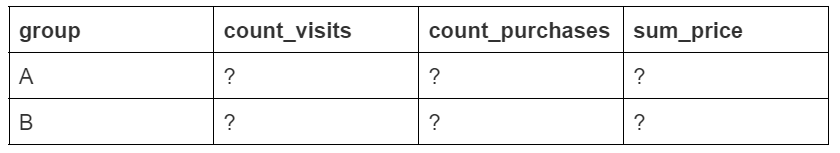
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [93]:
count_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visit', 'purchase': 'count_purchases',
                        'price': 'sum_price'})
count_data

,group,count_visit,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Тестовая и контрольная группы сопоставимы по количеству посещений (разница ~0.05%); выборки можно считать сбалансированными.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [94]:
count_data['conversion'] = round(count_data['count_purchases']/count_data['count_visit'], 4)*100
count_data['mean_check'] = round(count_data['sum_price']/count_data['count_purchases'])
count_data

,group,count_visit,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Tестовый вариант (B) выглядит более эффективным по величине среднего чека и лишь незначительно менее эффективным по конверсии. Требуется проверка статистической значимости различий.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [95]:
pivot_tab = pd.pivot_table(updated_data, 
    values='purchase', index='group', columns='price', aggfunc='count')
pivot_tab.drop(0, axis=1, inplace=True)
display(pivot_tab)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


In [96]:
p_g = updated_data.groupby('price')['group'].value_counts()
p_g

price   group
0       B        128091
        A        127820
10000   B          5201
        A          5182
60000   A          5271
        B          1730
100000  B          5227
        A          1832
150000  A          3478
        B          3438
200000  A          1724
        B          1694
Name: group, dtype: int64

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

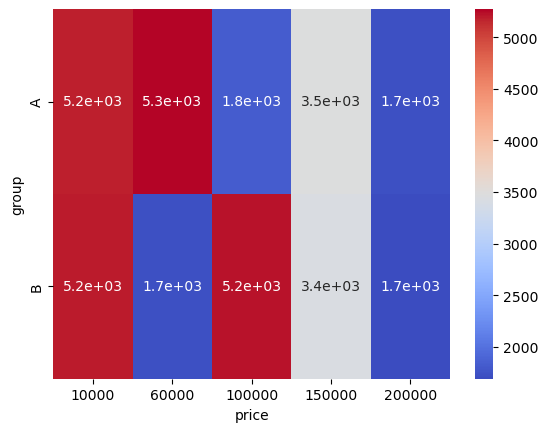

In [97]:
sns.heatmap(pivot_tab, annot=True, cmap='coolwarm');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?



Заметны большие различия между группами в покупке туров за 60000 и 100000 р. Участники тестовой группы (B) покупают значительно больше туров за 100000, в то время как покупка туров за 60000 у них существенно снижена относительно контрольной группы A.


## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [98]:
daily = updated_data.groupby(['date', 'group']) \
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}) \
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 
             'price': 'sum_price'})
daily['conversion'] \
    = (daily['count_purchases'] / daily['count_visits'] * 100).round(2)
daily['mean_check'] \
    = (daily['sum_price'] / daily['count_purchases']).round()
daily.loc['2021-01-03']

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,6596,748,62000000,11.34,82888.0
B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [99]:
daily['cum_count_visits'] = daily.groupby(['group'])['count_visits'].cumsum()
daily['cum_count_purchases'] = daily.groupby(['group'])['count_purchases'].cumsum()
daily['cum_sum_price'] = daily.groupby(['group'])['sum_price'].cumsum()

conv = (daily['cum_count_purchases']/daily['cum_count_visits'])*100.
conv.loc['2021-01-20']

group
A    11.983770
B    11.895911
dtype: float64

In [100]:
daily['cum_conv'] = ((daily['cum_count_purchases']/daily['cum_count_visits'])*100).round(2)
daily['cum_conv'] .loc['2021-01-20']

group
A    11.98
B    11.90
Name: cum_conv, dtype: float64

In [101]:
daily['cum_mean_check'] = (daily['cum_sum_price']/daily['cum_count_purchases']).round()
daily['cum_mean_check'].loc['2021-01-12']

group
A    81492.0
B    88352.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

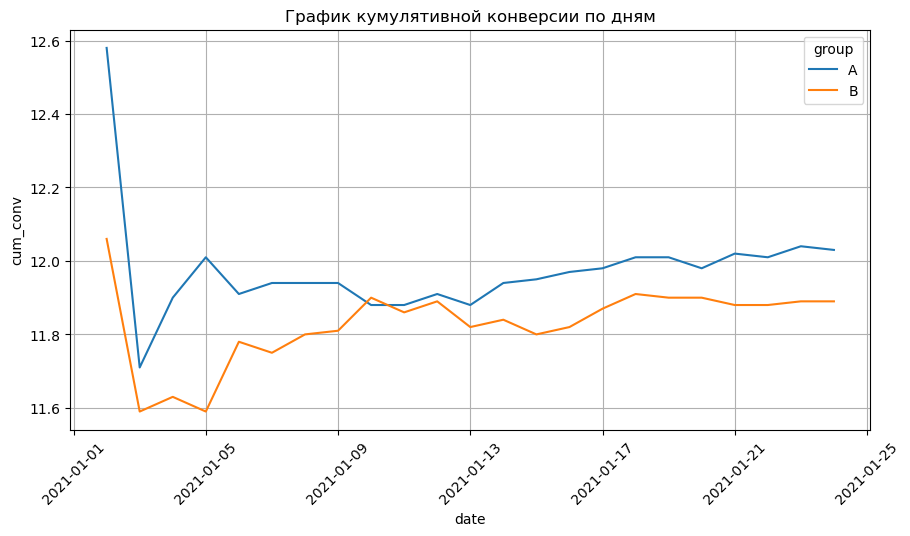

In [102]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conv', data=daily, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

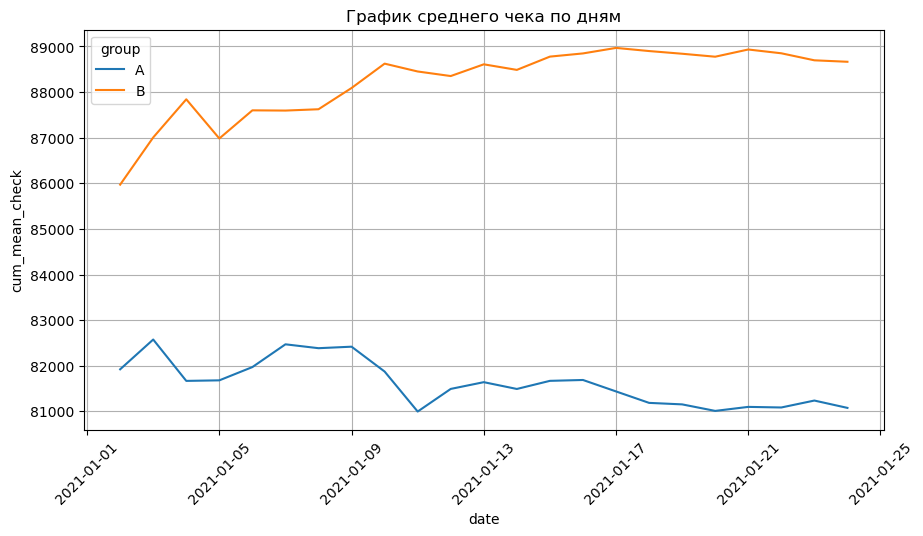

In [103]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Кумулятивные метрики стабилизировались, A/B-тестирование можно считать завершенным. Кумулятивная конверсия в тестовой группе (B) несколько меньше конверсии в контрольной группе (A). Кумулятивный средний чек тестовой группы выше с первого дня и на всем протяжении тестирования

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [104]:

# Считаем показатели пропорциq по группам: число успехов (success), число попыток (nobs)
proportion_tab = updated_data.groupby('group')['purchase'].agg(['sum', 'count']) \
    .rename(columns={'sum': 'success', 'count': 'nobs'})

In [105]:

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=proportion_tab['success'], #число "успехов"
    nobs=proportion_tab['nobs'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

p-value превышает заданный уровень значимости = 0.05, следовательно нулевую гипотезу отвергнуть нельзя, а разница конверсий статистически незначима

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [115]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [117]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [118]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [119]:

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы для конверсий в тестовой и контрольной группах значительно перекрываются. Доверительный интервал для разницы пропорций включает в себя ноль (левая граница - в области отрицательных значений, правая - в области положительных), это показывает, что различие конверсий статистически незначимо.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [130]:


daily = daily.reset_index()  # Индексы в колонки
# Выборки средних чеков в группах:
mean_check_A = daily[daily['group'] == 'A']['mean_check']
mean_check_B = daily[daily['group'] == 'B']['mean_check']

_, p = shapiro(mean_check_A)
print(f'Группа A, p-value = {p:.3f}')

_, p = shapiro(mean_check_B)
print(f'Группа B, p-value = {p:.3f}')



Группа A, p-value = 0.253
Группа B, p-value = 0.094


Для проверки распределений на нормальность применим тест Shapiro-Wilk. Устанавливаем стандартный уровень значимости
= 0.05.
Нулевая гипотеза - распределение нормальное, альтернативная гипотеза - распределение отлично от нормального.
В обеих группах p-value превышает установленный уровень значимости, следовательно нулевая гипотеза не отвергается, распределения можно считать нормальными.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [131]:


_, p = ttest_ind(mean_check_A, mean_check_B, alternative='less')
print(f'p-value = {p:.3e}')



p-value = 1.128e-12


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?



Применяем односторонний t-критерий для независимых выборок. Значение p-value меньше установленного уровня значимости, следовательно нулевая гипотеза о равенстве средних чеков отвергается, и принимается альтернативная - средний чек в группе A меньше, чем в группе B.


## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [133]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
daily = daily.reset_index()  # Индексы в колонки

a_daily_data = daily[daily['group'] == 'A']
b_daily_data = daily[daily['group'] == 'B']
 
params_a = {
    'n': a_daily_data['count_visits'].count(), # размер выборки
    'x_mean': a_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': a_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_daily_data['count_visits'].count(),# размер выборки
    'x_mean': b_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': b_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?



Доверительные интервалы для групп A и B не пересекаются, различия в среднем чеке статистически значимы.
Сделайте общий вывод по результатам A/B-теста

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В тестовой группе (B) средний чек выше, чем в контрольной (А), при этом различия в конверсиях нет (различие статистически незначимо). Таким образом, применение варианта дизайна B позволит увеличить прибыль. Анализ количества продаж в зависимости от стоимости тура показывает, что в тестовой группе B увеличение среднего чека происходит за счет того, что при выборе между турами за 60 т.р. и 100 т.р. клиенты выбирают более дорогостоящий тур чаще, чем в контрольной группе A.